# EDA ¿Quien es quien es los precios?

## Instrucción
El programa “Quién es Quién en los Precios” (QQP) es una iniciativa de la Procuraduría Federal del Consumidor (PROFECO) que recopila y publica los precios de productos de consumo básico en distintos establecimientos del país. Su objetivo es brindar transparencia y ayudar a los consumidores a comparar precios entre supermercados y tiendas.

En este análisis se estudian los datos correspondientes a supermercados ubicados en Hermosillo, Sonora, con el fin de identificar tendencias de precios, variaciones entre tiendas y posibles patrones de competencia local. Este trabajo forma parte de un ejercicio de Análisis Exploratorio de Datos (EDA) para conocer el comportamiento de los precios en la región.

## Preparativos

In [1]:
# Instala las bibliotecas necesarias
!uv add pandas
!uv add requests
!uv add rarfile
!uv add beautifulsoup4
!uv add matplotlib
!uv add seaborn
!uv add tqdm
!uv add geopandas
!uv add geopy
!uv add datetime
!uv add adjustText 

# Importa las bibliotecas
import pandas as pd
import requests as req
import rarfile as rar
from bs4 import BeautifulSoup
import os
import glob 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
from geopy.distance import geodesic
from datetime import datetime
from shapely.geometry import Point
from adjustText import adjust_text

Resolved 124 packages in 3ms
Audited 120 packages in 0.02ms
Resolved 124 packages in 4ms
Audited 120 packages in 0.02ms
Resolved 124 packages in 4ms
Audited 120 packages in 0.03ms
Resolved 124 packages in 5ms
Audited 120 packages in 0.03ms
Resolved 124 packages in 5ms
Audited 120 packages in 0.03ms
Resolved 124 packages in 4ms
Audited 120 packages in 0.03ms
Resolved 124 packages in 4ms
Audited 120 packages in 0.02ms
Resolved 124 packages in 5ms
Audited 120 packages in 0.03ms
Resolved 124 packages in 5ms
Audited 120 packages in 0.03ms
Resolved 124 packages in 6ms
Audited 120 packages in 0.04ms
Resolved 124 packages in 4ms
Audited 120 packages in 0.03ms


## Paso 1: Obtener Hashes de las urls a descargar

En lugar de descargar manualmente cada archivo .rar por año, vamos automatizar este proceso. Usaremos BeautifulSoup para encontrar los enlaces de descarga en la página de datos abiertos de la Profeco. Luego, usaremos requests para descargar cada archivo y rarfile para descomprimirlos, creando una estructura de directorios con todos los CSV desde 2015 hasta 2024.

In [2]:
# Obtener hashes de cada año
print("Extrayendo enlaces de descarga del sitio web de Profeco...")
base_url = "https://datos.profeco.gob.mx/datos_abiertos/"
pagina_web_url = base_url + "qqp.php#"

hashes_por_año = {}

try:
    r = req.get(pagina_web_url, timeout=10)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # Buscar el contenedor de los enlaces y extraer los hashes
    links = soup.select(".form-group li a")
    
    if not links:
        print("No se encontraron enlaces de descarga. La estructura del sitio web pudo haber cambiado.")
    else:
        for link in links:
            url_completa = link.get('href')
            nombre_archivo = link.text.strip()
            
            # Extraer el hash del enlace y el año del texto
            if url_completa and 't=' in url_completa and nombre_archivo:
                hash_valor = url_completa.split('t=')[-1]
                año = nombre_archivo[-4:]
                
                # Almacenar en el diccionario, verificando que el año sea numérico
                if año.isdigit():
                    hashes_por_año[int(año)] = hash_valor
                    
        print(f"Se encontraron {len(hashes_por_año)} archivos para descargar.")

except req.RequestException as e:
    print(f"Error al conectar con la página web: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado al extraer los datos: {e}")

Extrayendo enlaces de descarga del sitio web de Profeco...
Se encontraron 11 archivos para descargar.


## Paso 2: Descargar y descomprimir los archivos 
 
Esta celda automatiza la **descarga y descompresión** de archivos .RAR para cada año del dataset.    
- **Genera la URL de descarga** usando un hash único por año.  
- **Verifica si el archivo ya existe** para evitar descargas duplicadas.  
- **Descarga el archivo con barra de progreso** usando `tqdm`.  
- **Descomprime automáticamente** el contenido en la carpeta `./Datos/CSV`.  
- **Maneja errores y limpia archivos incompletos** si algo falla.  

### Objetivo  
Centralizar y automatizar el proceso para **no descargar manualmente cada archivo** año por año.  

In [3]:
# Paso 2: Bucle para descargar y descomprimir cada archivo
for año, hash_valor in hashes_por_año.items():
    # Construir la URL completa
    url_descarga = base_url + "file.php?t=" + hash_valor
    
    # Definir la ruta del archivo y del directorio
    ruta_archivo = f"./Datos/QQP_{año}.rar"
    ruta_extraccion = f"./Datos/CSV"
    
    # Verificar si el archivo RAR ya existe para evitar descargas redundantes
    if os.path.exists(ruta_archivo):
        print(f"El archivo del año {año} ya existe, saltando la descarga.")
        continue # Ir al siguiente año en el bucle
    
    print(f"Descargando el archivo del año {año}...")
    
    try:
        r = req.get(url_descarga, stream=True)
        r.raise_for_status()
        
        # Obtener el tamaño total del archivo para la barra de progreso
        total_size = int(r.headers.get('content-length', 0))
        
        # Guardar el archivo en el disco con barra de progreso
        with open(ruta_archivo, 'wb') as f:
            # tqdm envuelve el iterador para mostrar el progreso
            with tqdm(total=total_size, unit='B', unit_scale=True, desc=f"Descargando {año}") as pbar:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
        print("Descarga exitosa.")
        
        # Descomprimir el archivo RAR
        try:
            with rar.RarFile(ruta_archivo, 'r') as f:
                f.extractall(ruta_extraccion)
            print(f"Descompresión de {ruta_archivo} exitosa.")
        except rar.Error as e:
            print(f"Error descomprimiendo el archivo {ruta_archivo}: {e}")
            os.remove(ruta_archivo) # Opcional: eliminar el archivo incompleto
            
    except req.RequestException as e:
        print(f"Error descargando el archivo del año {año}: {e}")

print("\n¡Proceso de descarga y descompresión completado!")

El archivo del año 2025 ya existe, saltando la descarga.
El archivo del año 2024 ya existe, saltando la descarga.
El archivo del año 2023 ya existe, saltando la descarga.
El archivo del año 2022 ya existe, saltando la descarga.
El archivo del año 2021 ya existe, saltando la descarga.
El archivo del año 2020 ya existe, saltando la descarga.
El archivo del año 2019 ya existe, saltando la descarga.
El archivo del año 2018 ya existe, saltando la descarga.
El archivo del año 2017 ya existe, saltando la descarga.
El archivo del año 2016 ya existe, saltando la descarga.
El archivo del año 2015 ya existe, saltando la descarga.

¡Proceso de descarga y descompresión completado!


## Paso 3: Procesamiento y Filtrado de Archivos CSV  

Esta celda se encarga de **leer, procesar y filtrar** todos los archivos CSV descargados previamente.    
- **Busca todos los archivos CSV** en la carpeta `./Datos/CSV/`.  
- **Define nombres de columnas y tipos de datos** para optimizar la carga de información.  
- **Lee cada archivo CSV** mostrando progreso con `tqdm`.  
- **Filtra únicamente los registros del estado de SONORA y municipio de HERMOSILLO**.  
- **Concatena los DataFrames filtrados** en uno solo para análisis posterior.  
- **Maneja errores en la carga** de archivos para no detener el proceso.  

### Objetivo  
Centralizar y optimizar el procesamiento de datos, quedándonos solo con la **información relevante de Sonora y Hermosillo** para análisis y visualización posteriores.  


In [4]:
print("\nIniciando el procesamiento de los archivos CSV...")

# Lista de DataFrames
df_list = []

# Nombre de las series
column_names = [
    "PRODUCTO", "PRESENTACIÓN", "MARCA", "CATEGORÍA", "CATÁLOGO",
    "PRECIO", "FECHAREGISTRO", "CADENACOMERCIAL", "GIRO",
    "NOMBRECOMERCIAL", "DIRECCIÓN", "ESTADO", "MUNICIPIO",
    "LATITUD", "LONGITUD",
]

# Definir variables que sera string
dtype_dict = {
    col: 'string' for col in [
        "PRODUCTO", "PRESENTACIÓN", "MARCA", "CATEGORÍA", "CATÁLOGO",
        "CADENACOMERCIAL", "GIRO", "NOMBRECOMERCIAL", "DIRECCIÓN",
        "ESTADO", "MUNICIPIO"
    ]
}

#Definir variables flotantes
dtype_dict.update({
    "PRECIO": 'float64', "LATITUD": 'float64', "LONGITUD": 'float64'
})

# Encontrar todos los archivos CSV
all_csv_files = glob.glob("./Datos/CSV/**/*.csv", recursive=True)

# Leer y filtrar cada archivo para optimizar el procesamiento
for csv_file in tqdm(all_csv_files, desc="Filtrando y procesando CSVs"):
    try:
        df = pd.read_csv(
            csv_file,
            names=column_names,
            dtype=dtype_dict,
            parse_dates=["FECHAREGISTRO"],
            encoding='latin1' #Por si llega a tener un encoding
        )
        
        # Filtrar solo por el estado de 'SONORA' y el municipio de 'HERMOSILLO'
        df_masivo_filtrado = df[(df['ESTADO'] == 'SONORA') & (df['MUNICIPIO'] == 'HERMOSILLO')]
        
        # Solo agregar a la lista si el DataFrame filtrado no está vacío
        if not df_masivo_filtrado.empty:
            df_list.append(df_masivo_filtrado)
            
    except Exception as e:
        print(f"Error cargando {csv_file}: {e}")

# Concatenar los DataFrame
if df_list:
    df_sonora_hermosillo = pd.concat(df_list, ignore_index=True)    
    print(f"\nTotal de registros consolidados para Sonora y Hermosillo: {df_sonora_hermosillo.shape[0]}")
    print(f"Columnas: {df_sonora_hermosillo.shape[1]}")
else:
    print("No se encontraron datos para Sonora y Hermosillo en los archivos disponibles.")

print("\n¡Procesamiento completado!")


Iniciando el procesamiento de los archivos CSV...


Filtrando y procesando CSVs:  13%|█▋           | 65/484 [00:28<05:19,  1.31it/s]/var/folders/kl/5bfmq9vn7p1962v1r3vls0lm0000gn/T/ipykernel_2548/1089970545.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
Filtrando y procesando CSVs:  14%|█▊           | 69/484 [00:31<05:07,  1.35it/s]/var/folders/kl/5bfmq9vn7p1962v1r3vls0lm0000gn/T/ipykernel_2548/1089970545.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
Filtrando y procesando CSVs:  16%|██           | 77/484 [00:38<05:32,  1.22it/s]/var/folders/kl/5bfmq9vn7p1962v1r3vls0lm0000gn/T/ipykernel_2548/1089970545.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this 


Total de registros consolidados para Sonora y Hermosillo: 2300783
Columnas: 15

¡Procesamiento completado!


In [5]:
df_sonora_hermosillo.head().style.hide(axis='index')

PRODUCTO,PRESENTACIÓN,MARCA,CATEGORÍA,CATÁLOGO,PRECIO,FECHAREGISTRO,CADENACOMERCIAL,GIRO,NOMBRECOMERCIAL,DIRECCIÓN,ESTADO,MUNICIPIO,LATITUD,LONGITUD
AIRES ACONDICIONADOS,VM122C9. 12000 BTUÂ´S. TIPO MINISPLIT. DUAL INVERTER,LG,APARATOS ELECTRICOS,ELECTRODOMESTICOS,15999.000000,2022-05-23 00:00:00,COPPEL,TIENDA DE ELECTRODOMÃSTICOS,COPPEL SUCURSAL ELIAS CALLES,"ELIAS CALLES 8 PONIENTE, ENTRE MATAMOROS Y JUAREZ, COL. CENTRO, CP. 83000",SONORA,HERMOSILLO,29.078315,-110.951532
BARRA DE SONIDO,"SL4. BLUETOOTH, USB. POTENCIA 300W. SONIDO 2,1",LG,APARATOS ELECTRONICOS,ELECTRODOMESTICOS,4599.000000,2022-05-23 00:00:00,COPPEL,TIENDA DE ELECTRODOMÃSTICOS,COPPEL SUCURSAL ELIAS CALLES,"ELIAS CALLES 8 PONIENTE, ENTRE MATAMOROS Y JUAREZ, COL. CENTRO, CP. 83000",SONORA,HERMOSILLO,29.078315,-110.951532
BARRA DE SONIDO,"HT-S350. BLUETOOTH, USB. POTENCIA 320 W. SONIDO 2.1",SONY,APARATOS ELECTRONICOS,ELECTRODOMESTICOS,5399.000000,2022-05-23 00:00:00,COPPEL,TIENDA DE ELECTRODOMÃSTICOS,COPPEL SUCURSAL ELIAS CALLES,"ELIAS CALLES 8 PONIENTE, ENTRE MATAMOROS Y JUAREZ, COL. CENTRO, CP. 83000",SONORA,HERMOSILLO,29.078315,-110.951532
BATIDORAS,MX1500W. MANUAL. 5 VELOCIDADES. SIN TAZON,BLACK + DECKER,APARATOS ELECTRICOS,ELECTRODOMESTICOS,469.000000,2022-05-23 00:00:00,COPPEL,TIENDA DE ELECTRODOMÃSTICOS,COPPEL SUCURSAL ELIAS CALLES,"ELIAS CALLES 8 PONIENTE, ENTRE MATAMOROS Y JUAREZ, COL. CENTRO, CP. 83000",SONORA,HERMOSILLO,29.078315,-110.951532
BATIDORAS,62650. MANUAL. 6 VELOCIDADES. SIN TAZÃN,HAMILTON BEACH,APARATOS ELECTRICOS,ELECTRODOMESTICOS,769.000000,2022-05-23 00:00:00,COPPEL,TIENDA DE ELECTRODOMÃSTICOS,COPPEL SUCURSAL ELIAS CALLES,"ELIAS CALLES 8 PONIENTE, ENTRE MATAMOROS Y JUAREZ, COL. CENTRO, CP. 83000",SONORA,HERMOSILLO,29.078315,-110.951532


## Paso 4: Filtrado por Tipo de Establecimiento y Listado de Categorías  

Esta celda filtra el DataFrame consolidado para quedarse **solo con supermercados, tiendas de autoservicio, de conveniencia y mercados**, y luego lista las categorías únicas de productos.   
- **Define una lista de giros de interés** (`SUPERMERCADO`, `TIENDA DE CONVENIENCIA`, `MERCADOS`).  
- **Filtra el DataFrame** `df_sonora_hermosillo` para incluir únicamente esos giros.  
- **Obtiene y ordena las categorías únicas** de productos disponibles en estos establecimientos.  
- **Imprime las categorías** para conocer la variedad de productos disponibles.  

### Objetivo  
Enfocar el análisis únicamente en **supermercados, tiendas de conveniencia y mercados** y tener una **vista clara de las categorías de productos** presentes en esos establecimientos.  


In [6]:
# Lista de categorías de la canasta básica
canasta_basica = [
    'TORTILLAS Y DERIVADOS DEL MAIZ',
    'PAN',
    'ARROZ Y CEREALES PREPARADOS',
    'LEGUMBRES SECAS',
    'ACEITES Y GRASAS VEG. COMESTIBLES',
    'GRASAS ANIMALES COMESTIBLES',
    'AZUCAR',
    'CAFE',
    'LECHE FRESCA',
    'LECHE PROCESADA',
    'HUEVO',
    'FRUTAS FRESCAS',
    'HORTALIZAS FRESCAS',
    'CARNES FRIAS SECAS Y EMBUTIDOS',
    'CARNE Y VISCERAS DE RES',
    'CARNE Y VISCERAS DE CERDO',
    'CARNE DE AVE',
]

# Lista de giros de interés
giros_interes = ['SUPERMERCADO / TIENDA DE AUTOSERVICIO', 'TIENDA DE CONVENIENCIA', 'MERCADOS']

# Filtrar primero por giros
df_filtrado = df_sonora_hermosillo[df_sonora_hermosillo['GIRO'].isin(giros_interes)]

# Luego filtrar por categorías de la canasta básica
df_canasta = df_filtrado[df_filtrado['CATEGORÍA'].isin(canasta_basica)]

# Imprimir las categorías únicas del DataFrame final
print("Categorías de la canasta básica encontradas:")
print(df_canasta['CATEGORÍA'].unique())

Categorías de la canasta básica encontradas:
<StringArray>
['ACEITES Y GRASAS VEG. COMESTIBLES',                'HORTALIZAS FRESCAS',
                    'FRUTAS FRESCAS',       'ARROZ Y CEREALES PREPARADOS',
                            'AZUCAR',                              'CAFE',
         'CARNE Y VISCERAS DE CERDO',                      'CARNE DE AVE',
           'CARNE Y VISCERAS DE RES',                   'LEGUMBRES SECAS',
    'CARNES FRIAS SECAS Y EMBUTIDOS',                   'LECHE PROCESADA',
    'TORTILLAS Y DERIVADOS DEL MAIZ',                             'HUEVO',
                               'PAN',       'GRASAS ANIMALES COMESTIBLES',
                      'LECHE FRESCA']
Length: 17, dtype: string


In [7]:
df_canasta.head().style.hide(axis='index')

PRODUCTO,PRESENTACIÓN,MARCA,CATEGORÍA,CATÁLOGO,PRECIO,FECHAREGISTRO,CADENACOMERCIAL,GIRO,NOMBRECOMERCIAL,DIRECCIÓN,ESTADO,MUNICIPIO,LATITUD,LONGITUD
ACEITE,BOTELLA 946 ML. CANOLA,CANOIL,ACEITES Y GRASAS VEG. COMESTIBLES,BASICOS,44.900000,2022-05-23 00:00:00,LEY (AUTOSERVICIO),SUPERMERCADO / TIENDA DE AUTOSERVICIO,LEY SUCURSAL VADO DEL RIO,"PERIFERICO PONIENTE, ESQ. VADO DEL RIO, COL. PROYECTO RIO SONORA, CP. 83000",SONORA,HERMOSILLO,29.066052,-110.969103
ACEITE,BOTELLA 840 ML. CANOLA,CAPULLO,ACEITES Y GRASAS VEG. COMESTIBLES,BASICOS,48.900000,2022-05-23 00:00:00,LEY (AUTOSERVICIO),SUPERMERCADO / TIENDA DE AUTOSERVICIO,LEY SUCURSAL VADO DEL RIO,"PERIFERICO PONIENTE, ESQ. VADO DEL RIO, COL. PROYECTO RIO SONORA, CP. 83000",SONORA,HERMOSILLO,29.066052,-110.969103
ACEITE,BOTELLA 765 ML. MAÃZ,MAZOLA,ACEITES Y GRASAS VEG. COMESTIBLES,BASICOS,58.500000,2022-05-23 00:00:00,LEY (AUTOSERVICIO),SUPERMERCADO / TIENDA DE AUTOSERVICIO,LEY SUCURSAL VADO DEL RIO,"PERIFERICO PONIENTE, ESQ. VADO DEL RIO, COL. PROYECTO RIO SONORA, CP. 83000",SONORA,HERMOSILLO,29.066052,-110.969103
ACEITE,BOTELLA 946 ML. CARTAMO,OLEICO,ACEITES Y GRASAS VEG. COMESTIBLES,BASICOS,69.900000,2022-05-23 00:00:00,LEY (AUTOSERVICIO),SUPERMERCADO / TIENDA DE AUTOSERVICIO,LEY SUCURSAL VADO DEL RIO,"PERIFERICO PONIENTE, ESQ. VADO DEL RIO, COL. PROYECTO RIO SONORA, CP. 83000",SONORA,HERMOSILLO,29.066052,-110.969103
ACEITE,BOTELLA 850 ML. MIXTO. SABOR MANTEQUILLA,SABROSANO,ACEITES Y GRASAS VEG. COMESTIBLES,BASICOS,46.900000,2022-05-23 00:00:00,LEY (AUTOSERVICIO),SUPERMERCADO / TIENDA DE AUTOSERVICIO,LEY SUCURSAL VADO DEL RIO,"PERIFERICO PONIENTE, ESQ. VADO DEL RIO, COL. PROYECTO RIO SONORA, CP. 83000",SONORA,HERMOSILLO,29.066052,-110.969103


### Paso 5: Análisis de la variación de precios y visualización

Esta sección de código realiza un análisis detallado para **entender cómo han evolucionado los precios de los productos de la canasta básica a lo largo del tiempo**. El objetivo es identificar las categorías que han experimentado el mayor incremento de precios, para luego visualizarlas de forma clara y concisa.

#### **Proceso**

1.  **Preparación del DataFrame**: Iniciamos creando una copia del DataFrame original para no alterar los datos fuente. Preparamos la columna de fechas y extraemos el año, lo cual es fundamental para cualquier análisis temporal.
    
2.  **Cálculo del precio promedio**: Agrupamos los datos por año y categoría para obtener el precio promedio anual de cada producto. Esto nos permite una visión más simple y comparativa.
    
3.  **Análisis de la variación acumulada**: Para entender el impacto a largo plazo, calculamos la **variación porcentual acumulada**. Este valor muestra el cambio de precio de cada año con respecto al primer año registrado. Es la métrica clave para identificar la inflación en cada categoría.
    
4.  **Selección de las categorías clave**: Nos centramos en el año más reciente (2025) y seleccionamos las 8 categorías que muestran la mayor variación. Esto nos permite enfocar el análisis en los productos que han sufrido los aumentos de precio más significativos.
    
5.  **Visualización de tendencias**: Finalmente, usamos Seaborn para crear una serie de gráficos de línea. Cada gráfico representa una de las categorías seleccionadas y muestra su tendencia de precio a lo largo del tiempo. Esta visualización es crucial para un entendimiento rápido del comportamiento de los precios.

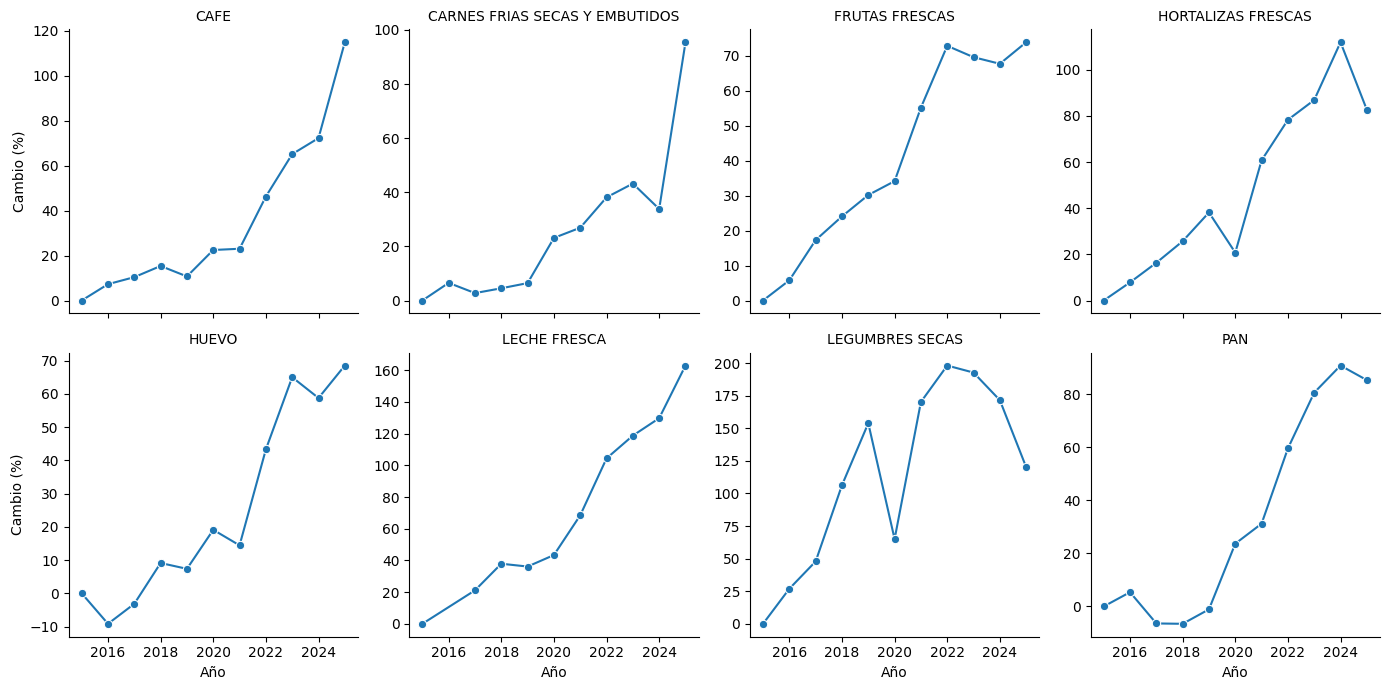

In [8]:
#Copiar el Data Frame
df_canasta_basica = df_canasta.copy()

# Convertir fechas y extraer año
df_canasta_basica['FECHAREGISTRO'] = pd.to_datetime(df_canasta_basica['FECHAREGISTRO'])
df_canasta_basica['AÑO'] = df_canasta_basica['FECHAREGISTRO'].dt.year

# Agrupar por año y categoría, calcular precio promedio
df_agrupado = df_canasta_basica.groupby(['AÑO', 'CATEGORÍA'])['PRECIO'].mean().reset_index()

# Calcular variación porcentual acumulada desde el primer año
df_agrupado['PRECIO_BASE'] = df_agrupado.groupby('CATEGORÍA')['PRECIO'].transform('first')
df_agrupado['VARIACION_%'] = ((df_agrupado['PRECIO'] - df_agrupado['PRECIO_BASE']) / df_agrupado['PRECIO_BASE']) * 100

# Seleccionar las 8 categorías con mayor variación en 2025
top_categorias = (
    df_agrupado[df_agrupado['AÑO'] == 2025]
    .sort_values('VARIACION_%', ascending=False)
    .head(8)['CATEGORÍA']
)

# Filtrar para graficar solo esas categorías
df_top = df_agrupado[df_agrupado['CATEGORÍA'].isin(top_categorias)]

# Crear gráficas separadas por categoría
g = sns.FacetGrid(df_top, col='CATEGORÍA', col_wrap=4, height=3.5, sharey=False)
g.map(sns.lineplot, 'AÑO', 'VARIACION_%', marker='o')
g.set_titles("{col_name}")
g.set_axis_labels("Año", "Cambio (%)")
plt.tight_layout()
plt.show()


### **Visualización de Precios por Ubicación Geográfica**

Este script genera un mapa de calor para **visualizar la distribución espacial de los precios promedio** en supermercados y mercados de Hermosillo. El objetivo es identificar las zonas de la ciudad donde los precios de la canasta básica son más altos o bajos.

#### **Proceso**

1.  **Carga y Proyección de Datos Geográficos**: Se carga el _shapefile_ de Hermosillo y se asegura que el sistema de coordenadas (CRS) sea **WGS 84 (latitud/longitud)** para una correcta visualización.
    
2.  **Filtrado de Datos**: Se seleccionan únicamente los registros de **supermercados y mercados** del DataFrame original. Se crea una columna de ubicación única para manejar sucursales con nombres o direcciones duplicadas.
    
3.  **Agregación de Precios**: Los datos se agrupan por ubicación para calcular el **precio promedio** en cada sucursal. Esto proporciona un único valor representativo para cada punto en el mapa.
    
4.  **Generación de Puntos en el Mapa**: Se crea un **GeoDataFrame** con la información de latitud y longitud, convirtiendo cada sucursal en un punto geográfico.
    
5.  **Visualización**: Se superponen los puntos de las sucursales sobre el mapa base de Hermosillo. El color de cada punto representa el precio promedio, creando un **mapa de calor**. Se ajustan las etiquetas de cada sucursal para evitar que se superpongan y se añade una leyenda para interpretar los colores.

/Users/pancakes/pcd2025/hola_qeqep2/.venv/lib/python3.11/site-packages/adjustText/__init__.py:419: UserWarning: Glyph 145 (\x91) missing from font(s) DejaVu Sans.
  ax.figure.draw_without_rendering()
/Users/pancakes/pcd2025/hola_qeqep2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 145 (\x91) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


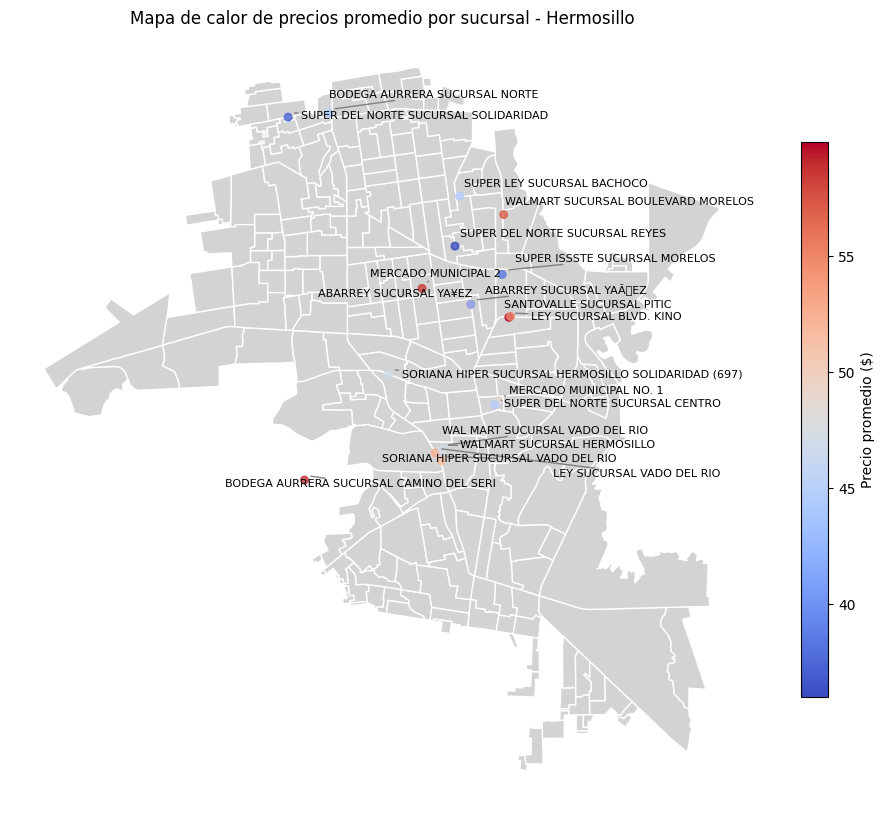

In [9]:
# 1. Cargar el shapefile base de Hermosillo
ageb1 = gpd.read_file('/Users/pancakes/pcd2025/hola_qeqep2/HERMOSILLO/AGEBS/Q0300001A.shp')

# 2. Asignar CRS original si está ausente (probablemente UTM zona 12N)
if ageb1.crs is None:
    ageb1.crs = 'EPSG:32612'

# 3. Reproyectar a lat/lon
ageb1 = ageb1.to_crs(epsg=4326)

# 4. Crear columna de ubicación única para evitar duplicados
df_canasta_basica['UBICACION'] = df_canasta_basica['NOMBRECOMERCIAL'] + ' | ' + df_canasta_basica['DIRECCIÓN']

# 5. Agrupar por ubicación y calcular precio promedio
gdf_promedios = (
    df_canasta_basica.groupby(['UBICACION', 'NOMBRECOMERCIAL', 'LATITUD', 'LONGITUD'])
    .agg({'PRECIO': 'mean'})
    .reset_index()
)

# 6. Crear geometría
gdf_promedios['geometry'] = gdf_promedios.apply(lambda row: Point(row['LONGITUD'], row['LATITUD']), axis=1)
gdf_promedios = gpd.GeoDataFrame(gdf_promedios, geometry='geometry', crs='EPSG:4326')

# 7. Visualizar mapa base + puntos + etiquetas ajustadas
fig, ax = plt.subplots(figsize=(12,12))
ageb1.plot(ax=ax, color='lightgrey', edgecolor='white')


gdf_promedios.plot(
    ax=ax,
    column='PRECIO',
    cmap='coolwarm',
    markersize=30,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Precio promedio ($)", 'shrink': 0.6}
)

# Ajustar etiquetas automáticamente para evitar empalmes
texts = []
for idx, row in gdf_promedios.iterrows():
    texts.append(ax.text(
        row['LONGITUD'] + 0.001,
        row['LATITUD'] + 0.001,
        row['NOMBRECOMERCIAL'],
        fontsize=8,
        color='black'
    ))

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title('Mapa de calor de precios promedio por sucursal - Hermosillo')
plt.axis('off')
plt.show()


## Visualización de la Dispersión de Precios por Categoría  

Esta celda genera un **boxplot** para visualizar la distribución de precios por categoría de producto.  

### ¿Qué hace este bloque de código?  
- **Usa `seaborn` y `matplotlib`** para graficar.  
- **Crea un boxplot** donde:
  - `x = PRECIO` muestra los precios de los productos.
  - `y = CATEGORÍA` muestra las distintas categorías.  
- **Incluye todos los datos sin eliminar outliers**, mostrando la dispersión real.  
- **Ajusta el tamaño de la figura y título** para mejor presentación.  

### Objetivo  
Visualizar la **distribución y dispersión de precios** por categoría, detectando rangos, medianas y posibles outliers para un análisis más profundo de precios.  


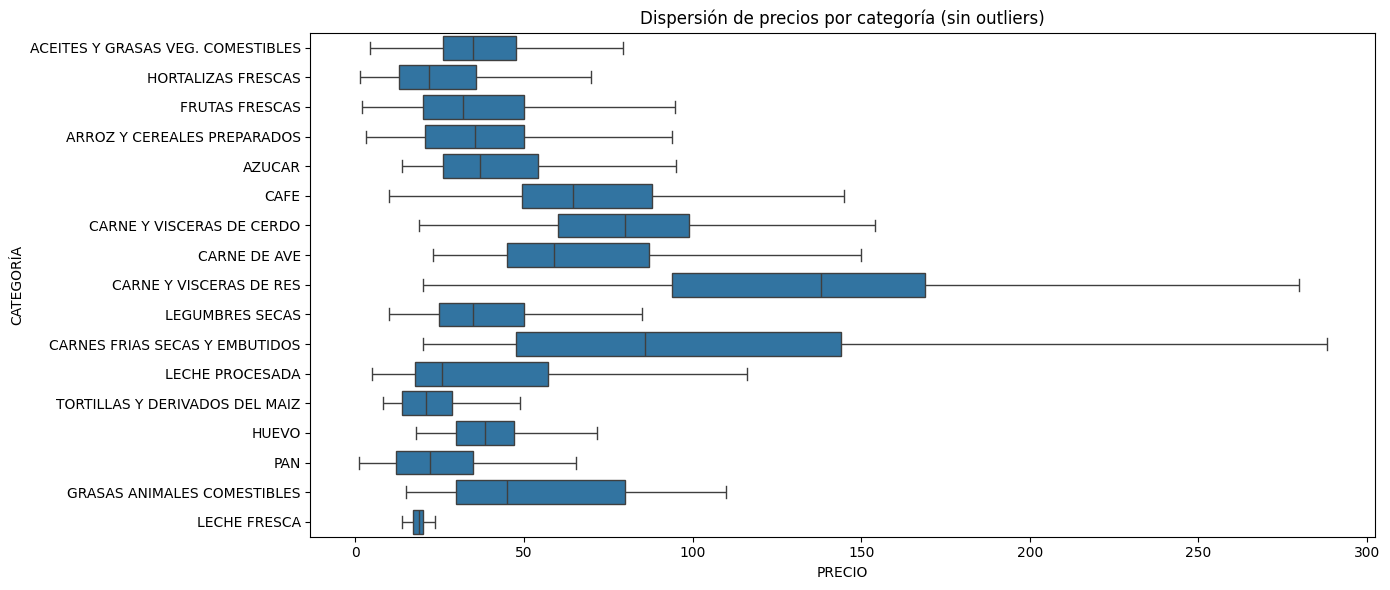

In [15]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_canasta_basica,
    y='CATEGORÍA',
    x='PRECIO',
    showfliers=False
)
plt.title('Dispersión de precios por categoría (sin outliers)')
plt.tight_layout()
plt.show()
